<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 01 - Multi-layer Perceptron (MLP)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 1 – REDE MLP

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:

  * Diferentes topologias (>=5 topologias, variar número de
camadas

  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  
  * Avaliar o impacto do uso do Momentum

  * Avaliar o impacto do uso da regularização (i.e. L2)
  
  * [EXTRA] Avaliar o impacto do Dropout

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math
import pandas as pd
import time # for time mesurment

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

print(tf.__version__)

2.8.2


In [2]:
print(np.__version__)

1.21.6


# Regression

## Dataset

This dataset refers to the PSD of the two-point correlation function of the Cosmic Background Radiation and is of great importance for the determination of the cosmological parameters.

This data set can be found at 
http://pla.esac.esa.int/pla/#cosmology



In [3]:
!wget "http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt"

--2022-07-13 21:51:46--  http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/x-binary]
Saving to: ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’

product-action?COSM     [     <=>            ] 166.55K   198KB/s    in 0.8s    

2022-07-13 21:51:48 (198 KB/s) - ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’ saved [170547]



In [4]:
df = pd.read_fwf('product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt')
df.columns = ["id","l", "Dl", "+dDl", "-dDl"]
df.drop('id', axis=1, inplace=True)

In [5]:
#Normalize data
#https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
df.l =  (df.l - df.l.mean()) / df.l.std()
df.Dl =  (df.Dl - df.Dl.mean()) / df.Dl.std()
df['+dDl'] =  (df['+dDl'] - df['+dDl'].mean()) / df['+dDl'].std()
df['+dDl'] =  (df['-dDl'] - df['-dDl'].mean()) / df['-dDl'].std()

$$ D_l = \frac{l(l+1)Cl}{(2\pi)} $$

[]

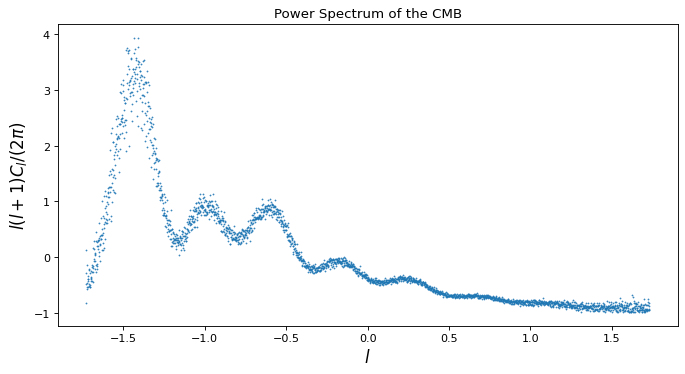

In [6]:
#from IPython.core.pylabtools import figsize
figure(figsize=(10,5),dpi=80)
plt.scatter(df.l,df.Dl,s=0.3)
#plt.errorbar(l, Dl, df.min_error, df.max_error, fmt='r^')
#plt.xscale('log')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.title("Power Spectrum of the CMB")
plt.plot()


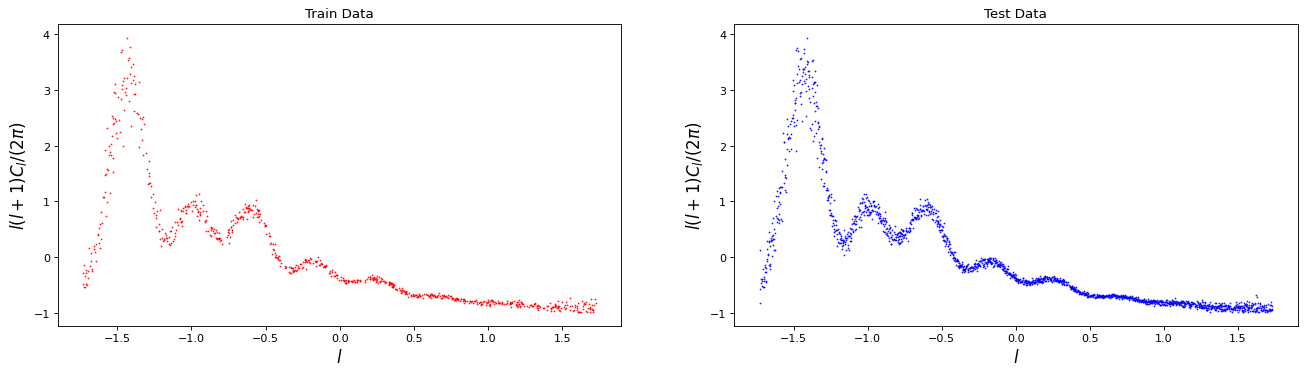

In [7]:
# Spliting in traing and Validation 
x_train, x_test, y_train, y_test = train_test_split(df.l, df.Dl, test_size=0.7)
# print(len(x_train))
# print(len(x_test))
figure(figsize=(20,5),dpi=80)

plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='red',s=0.3)
plt.title('Train Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
#plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='blue',s=0.3)
plt.title('Test Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
#plt.xscale('log')
plt.show()


## Comun parametes

In [8]:
#Paramentes
adam = tf.keras.optimizers.Adam()

## Topology 1

To attempt to build a network capable of finding a regression law for these problems, we will generate 5 different network topologies. The first will be the simple and classic case of a perceptron and the second will increase the number of layers and the number of neurons.

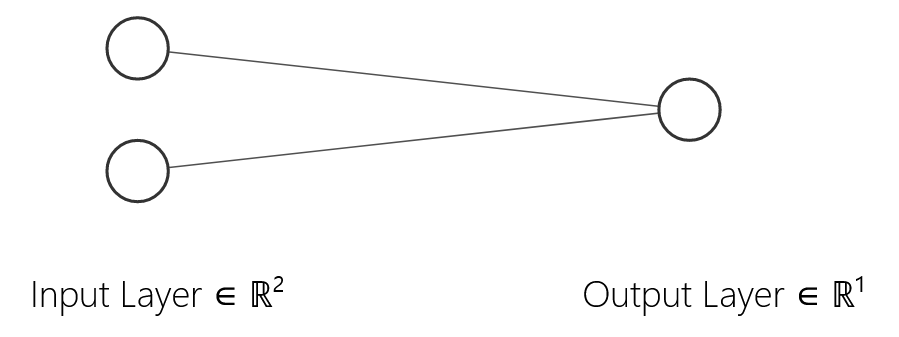

### Models of Topology 1

In [9]:
model_1 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_1.append(keras.Sequential())
  model_1[i].add(keras.layers.Dense(units=3,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_1[i].add(Dropout(dropo[i]))
  model_1[i].add(keras.layers.Dense(units=1,kernel_regularizer=l2(regul[i]), activation="linear"))
  model_1[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

### Treining Topology 1

In [10]:
#O que é isso?
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___1 = []
endti___1 = []
history_1 = []
for i in range(len(regul)):
  start___1.append(time.time())
  history_1.append(
    model_1[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___1.append(time.time())

Epoch 1/10
61/61 [==============================] - 2s 11ms/step - loss: 0.3719 - mean_absolute_error: 0.3555 - val_loss: 0.4118 - val_mean_absolute_error: 0.3776
Epoch 2/10
61/61 [==============================] - 0s 5ms/step - loss: 0.3637 - mean_absolute_error: 0.3515 - val_loss: 0.4077 - val_mean_absolute_error: 0.3784
Epoch 3/10
61/61 [==============================] - 0s 4ms/step - loss: 0.3586 - mean_absolute_error: 0.3571 - val_loss: 0.4025 - val_mean_absolute_error: 0.3858
Epoch 4/10
61/61 [==============================] - 0s 5ms/step - loss: 0.3567 - mean_absolute_error: 0.3550 - val_loss: 0.4006 - val_mean_absolute_error: 0.3834
Epoch 5/10
61/61 [==============================] - 0s 6ms/step - loss: 0.3548 - mean_absolute_error: 0.3530 - val_loss: 0.3985 - val_mean_absolute_error: 0.3812
Epoch 6/10
61/61 [==============================] - 0s 7ms/step - loss: 0.3526 - mean_absolute_error: 0.3503 - val_loss: 0.3958 - val_mean_absolute_error: 0.3808
Epoch 7/10
61/61 [=========

### Results Topology 1

In [11]:
#Time Running Out
for i in range(len(start___1)):
  print(round((    endti___1[i]- start___1[i])/60,5),'minuts')
print(round((      endti___1[-1]-start___1[0])/60,5),'minuts TOTAL')

0.09324 minuts
0.09808 minuts
0.10075 minuts
0.10074 minuts
0.086 minuts
0.10635 minuts
0.58516 minuts TOTAL


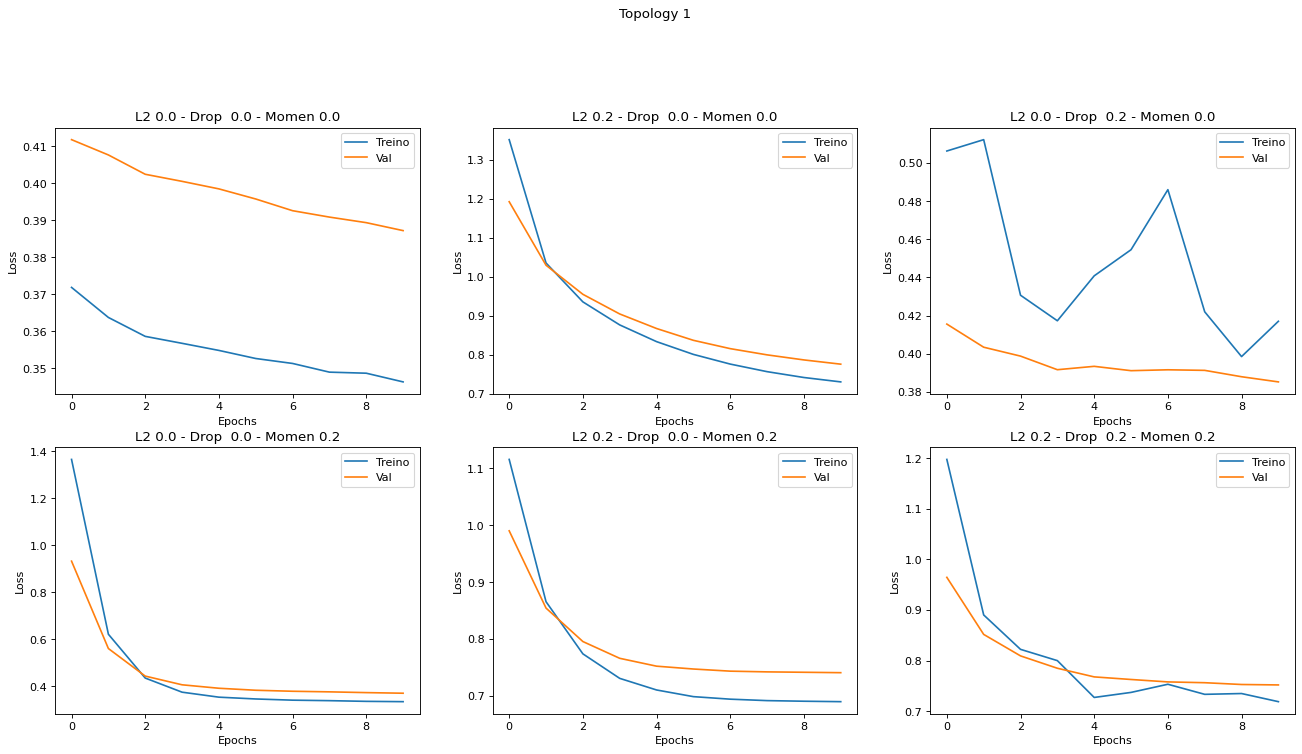

In [12]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("Topology 1")
for i in range(len(model_1)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(history_1[i].history['loss'], label="Treino")
  plt.plot(history_1[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation Topology 1

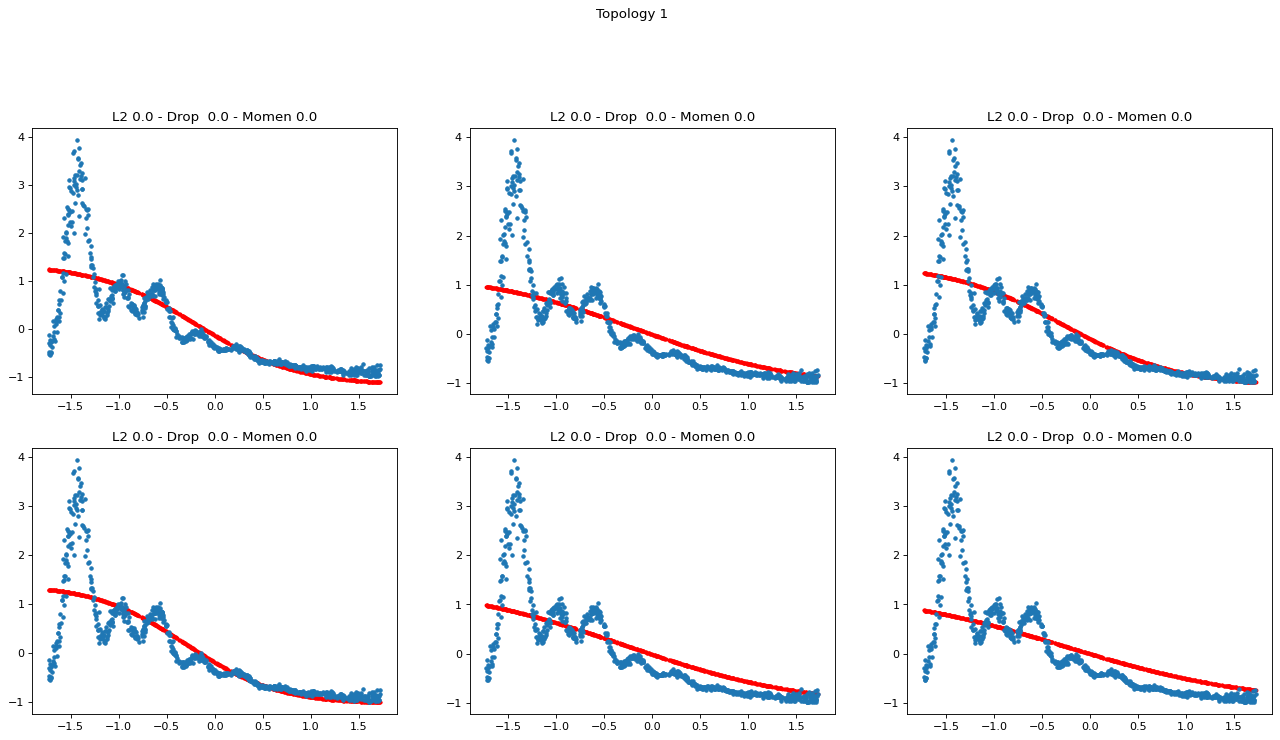

In [13]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 1')
for i in range(len( model_1)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_1[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

In [14]:
score_1 = []
for i in range(len(           model_1)): 
  score_1.append(             model_1[i].evaluate(x_test, y_test, verbose=0))
  print('Model_1'+str(i))
  print("Test loss:",   round(score_1[i][0],5))
  print("Test metric:", round(score_1[i][1],5),'\n')


Model_10
Test loss: 0.29977
Test metric: 0.31801 

Model_11
Test loss: 0.67152
Test metric: 0.3714 

Model_12
Test loss: 0.29733
Test metric: 0.29402 

Model_13
Test loss: 0.28712
Test metric: 0.29047 

Model_14
Test loss: 0.63678
Test metric: 0.38473 

Model_15
Test loss: 0.64066
Test metric: 0.41946 



## Topology 2 

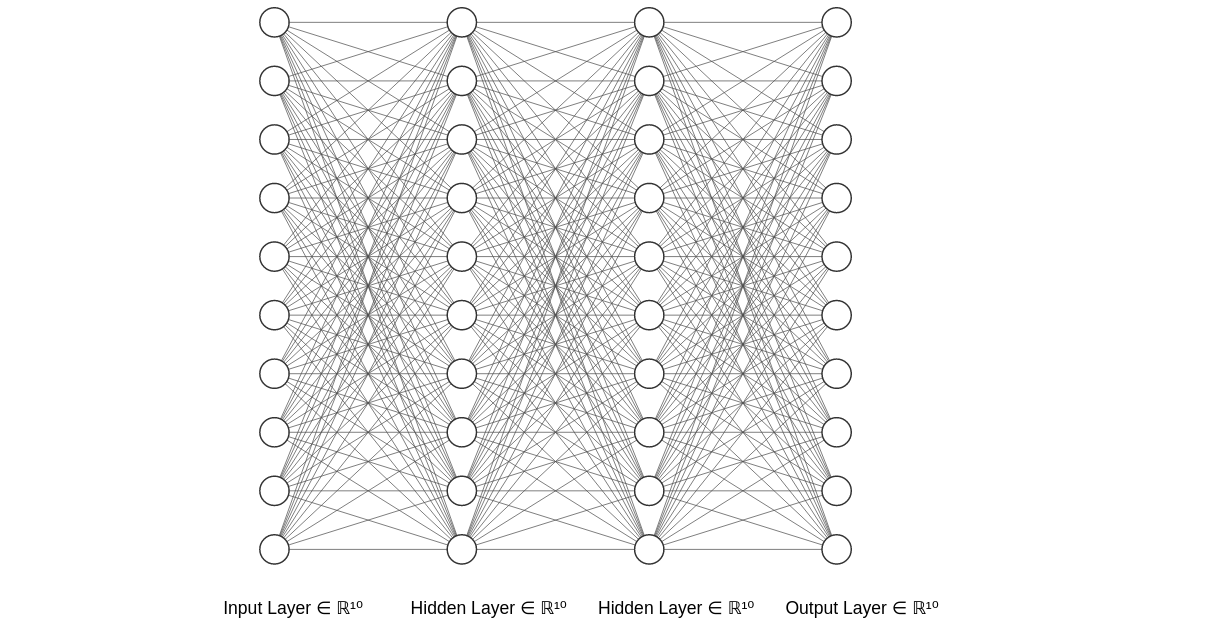

### Models for Topology 2


In [15]:
model_2 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_2.append(keras.Sequential())
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))  
  model_2[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_2[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Treining Topology 2



In [16]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___2 = []
endti___2 = []
history_2 = []
for i in range(len(regul)):
  start___2.append(time.time())
  history_2.append(
    model_2[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___2.append(time.time())

Epoch 1/10
61/61 [==============================] - 1s 6ms/step - loss: 0.4315 - mean_absolute_error: 0.4019 - val_loss: 0.3793 - val_mean_absolute_error: 0.3411
Epoch 2/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3390 - mean_absolute_error: 0.3194 - val_loss: 0.3746 - val_mean_absolute_error: 0.3247
Epoch 3/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3262 - mean_absolute_error: 0.3119 - val_loss: 0.3549 - val_mean_absolute_error: 0.3187
Epoch 4/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3254 - mean_absolute_error: 0.3078 - val_loss: 0.3565 - val_mean_absolute_error: 0.3259
Epoch 5/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3288 - mean_absolute_error: 0.3170 - val_loss: 0.3814 - val_mean_absolute_error: 0.3449
Epoch 6/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3329 - mean_absolute_error: 0.3133 - val_loss: 0.3575 - val_mean_absolute_error: 0.3322
Epoch 7/10
61/61 [==========

### Results Topology 2


In [17]:
#Time Running Out
for i in range(len(start___2)):
  print(round((    endti___2[i]- start___2[i])/60,5),'minuts')
print(round((      endti___2[-1]-start___2[0])/60,5),'minuts TOTAL')

0.04617 minuts
0.09629 minuts
0.05939 minuts
0.04778 minuts
0.04594 minuts
0.05561 minuts
0.35117 minuts TOTAL


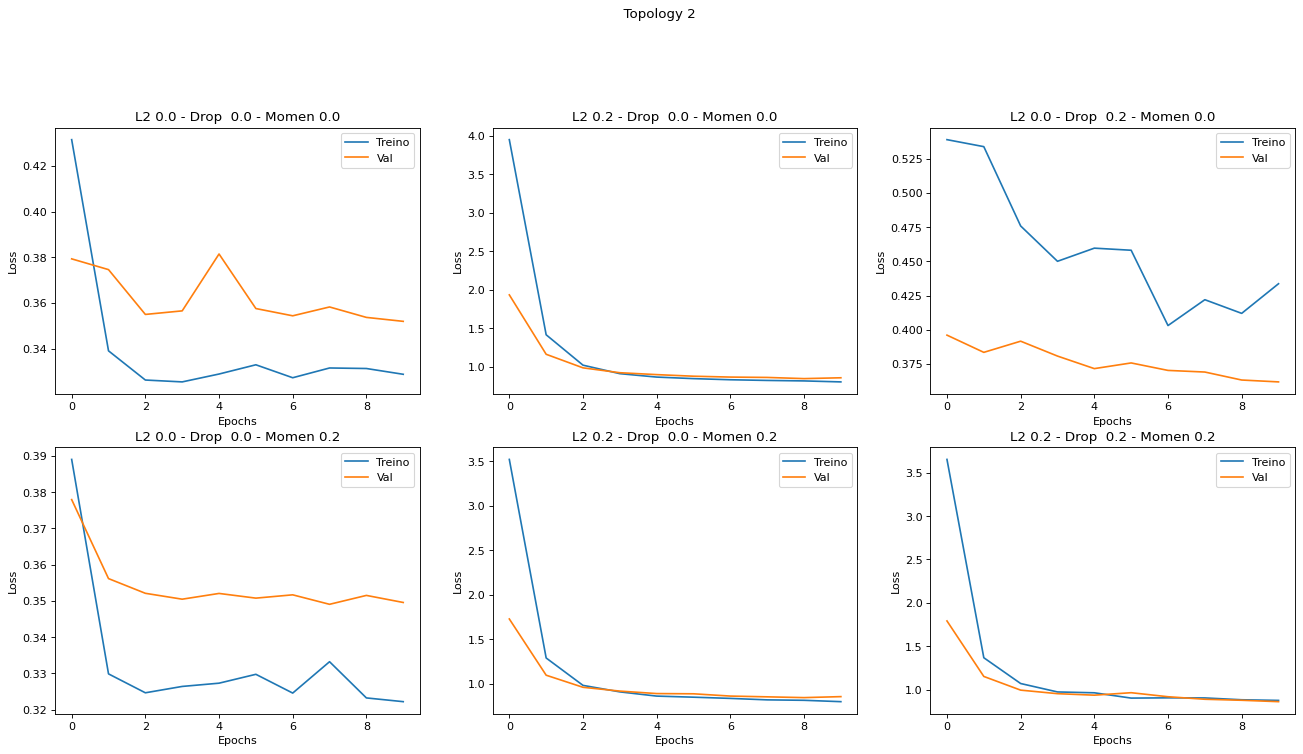

In [18]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 2")
for i in range(len(model_2)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_2[i].history['loss'], label="Treino")
  plt.plot(      history_2[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation Topology 2

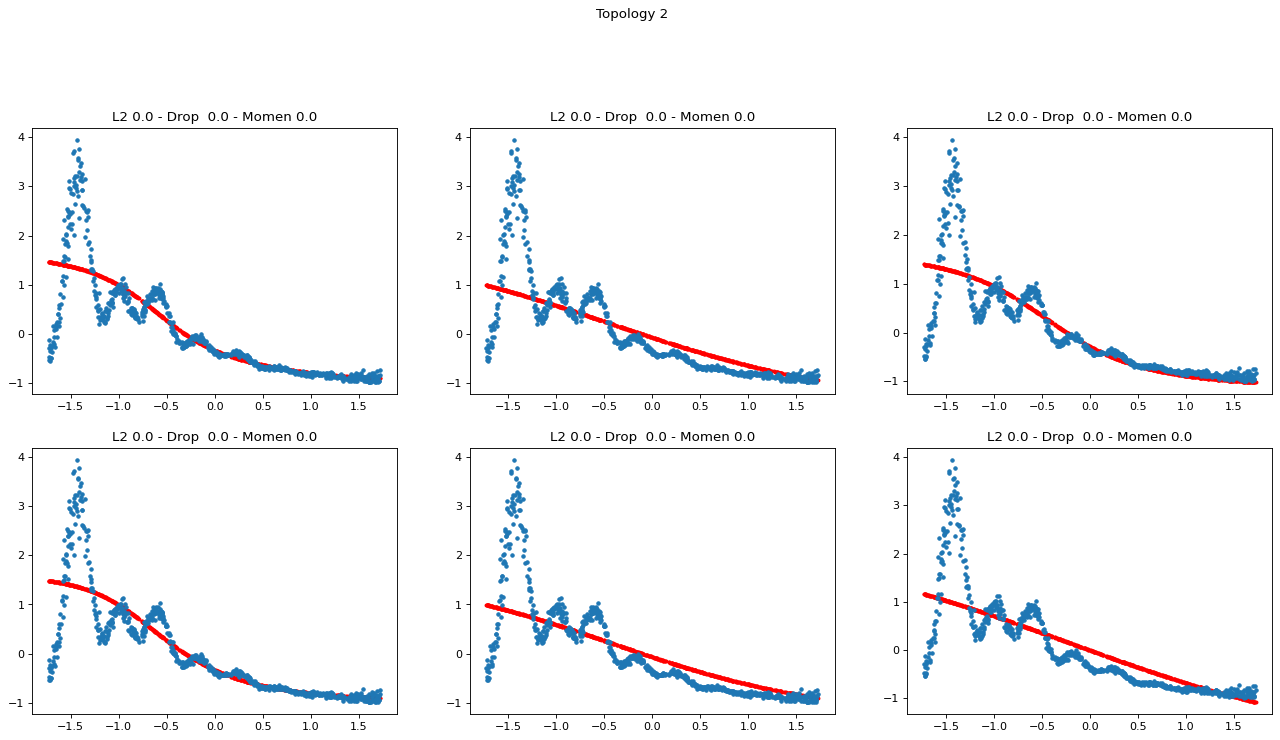

In [19]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 2')
for i in range(len( model_2)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_2[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

In [20]:
score_2 = []
for i in range(len(           model_2)): 
  score_2.append(             model_2[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_2'+str(i))
  print("Test loss:",   round(score_2[i][0],5))
  print("Test metric:", round(score_2[i][1],5),'\n')

Model_20
Test loss: 0.27341
Test metric: 0.26513 

Model_21
Test loss: 0.751
Test metric: 0.34833 

Model_22
Test loss: 0.27926
Test metric: 0.27891 

Model_23
Test loss: 0.27197
Test metric: 0.26508 

Model_24
Test loss: 0.74604
Test metric: 0.35524 

Model_25
Test loss: 0.76341
Test metric: 0.35096 



## Topology 3

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top5.png?raw=true">

### Models for Topology 3

In [31]:
model_3 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_3.append(keras.Sequential())
  model_3[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=40,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=30,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=20,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_3[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Training Topology 3

In [32]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___3 = []
endti___3 = []
history_3 = []
for i in range(len(regul)):
  start___3.append(time.time())
  history_3.append(model_3[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___3.append(time.time())

Epoch 1/10
61/61 [==============================] - 1s 7ms/step - loss: 0.3816 - mean_absolute_error: 0.3815 - val_loss: 0.4086 - val_mean_absolute_error: 0.3398
Epoch 2/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3453 - mean_absolute_error: 0.3235 - val_loss: 0.3487 - val_mean_absolute_error: 0.3176
Epoch 3/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3334 - mean_absolute_error: 0.3283 - val_loss: 0.3503 - val_mean_absolute_error: 0.3083
Epoch 4/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3295 - mean_absolute_error: 0.3200 - val_loss: 0.3478 - val_mean_absolute_error: 0.3160
Epoch 5/10
61/61 [==============================] - 0s 4ms/step - loss: 0.3246 - mean_absolute_error: 0.3089 - val_loss: 0.3543 - val_mean_absolute_error: 0.3264
Epoch 6/10
61/61 [==============================] - 0s 3ms/step - loss: 0.3317 - mean_absolute_error: 0.3286 - val_loss: 0.3563 - val_mean_absolute_error: 0.3251
Epoch 7/10
61/61 [==========

### Results Topology 3

In [33]:
#Time Running Out
for i in range(len(start___3)):
  print(round((    endti___3[i]- start___3[i])/60,5),'minuts')
print(round((      endti___3[-1]-start___3[0])/60,5),'minuts TOTAL')

0.05956 minuts
0.05422 minuts
0.05657 minuts
0.05614 minuts
0.09003 minuts
0.05516 minuts
0.37169 minuts TOTAL


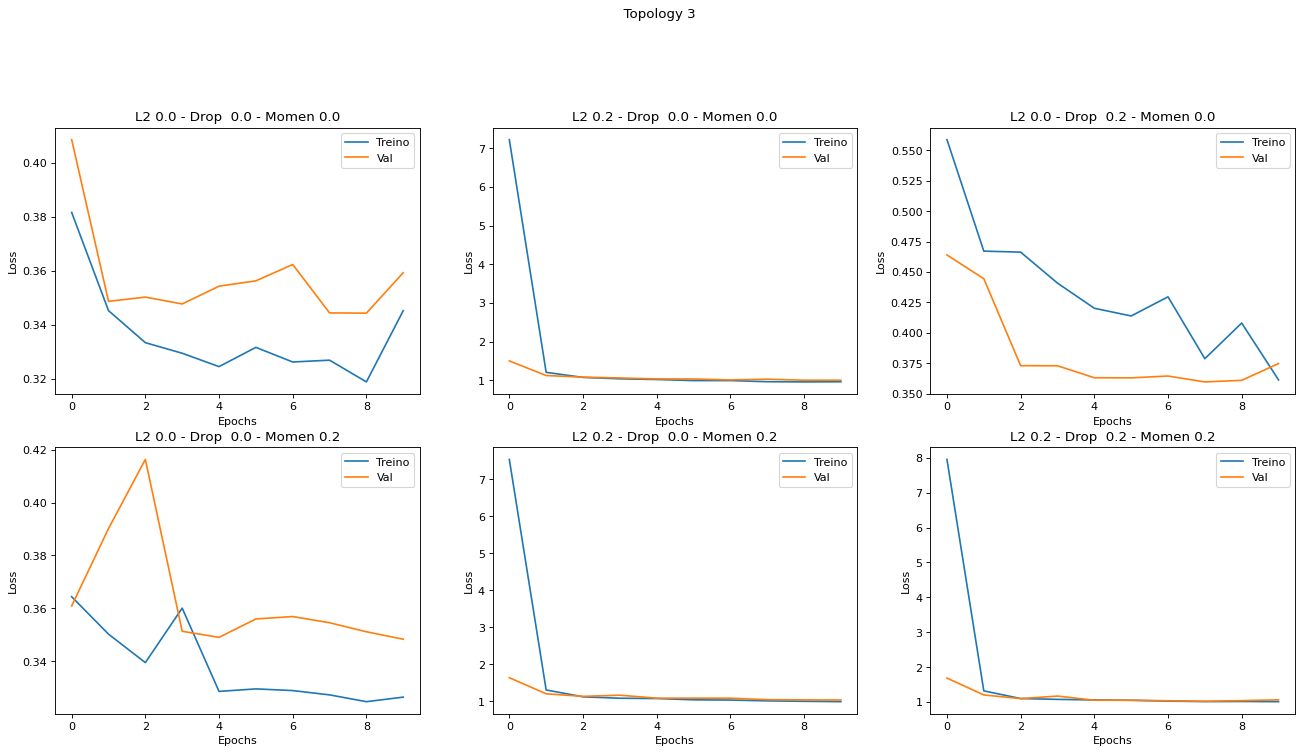

In [34]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 3")
for i in range(len(model_3)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_3[i].history['loss'], label="Treino")
  plt.plot(      history_3[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation Topology 3 



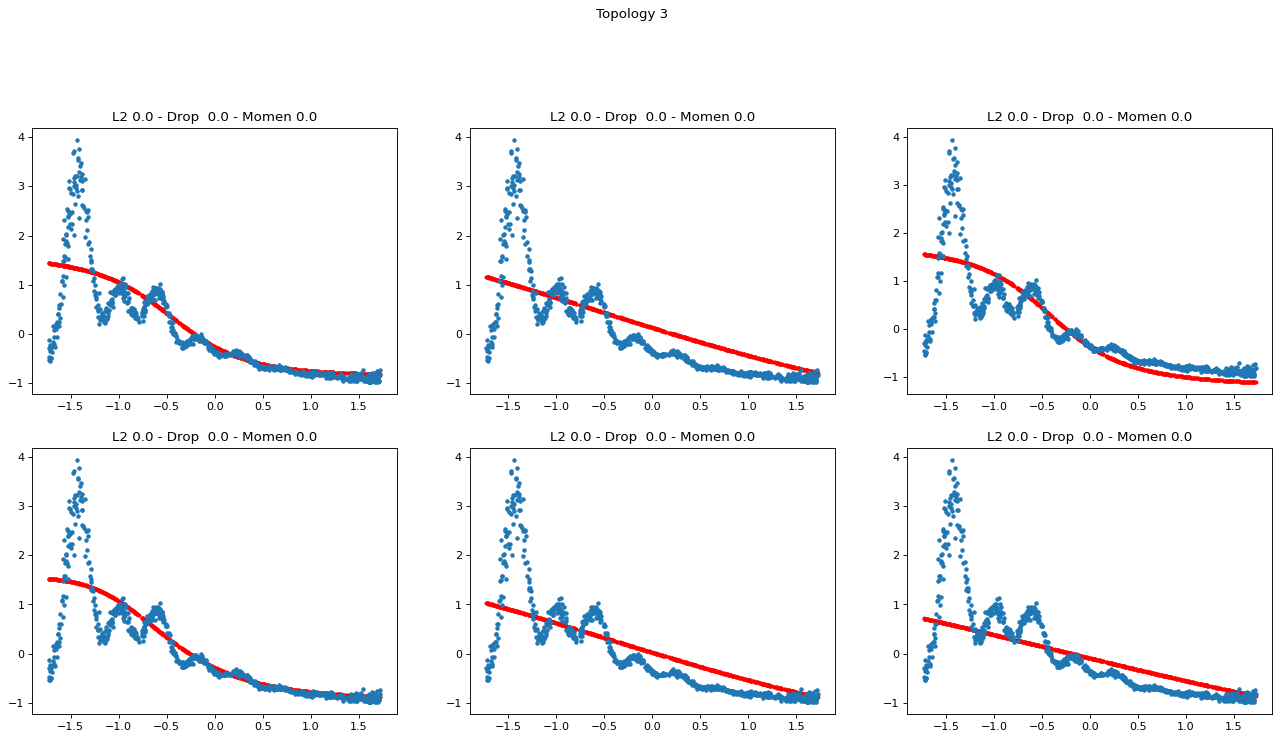

In [35]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 3')
for i in range(len( model_3)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_3[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

In [36]:
score_3 = []
for i in range(len(           model_3)): 
  score_3.append(             model_3[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_3'+str(i))
  print("Test loss:",   round(score_3[i][0],5))
  print("Test metric:", round(score_3[i][1],5),'\n')

Model_30
Test loss: 0.28119
Test metric: 0.28877 

Model_31
Test loss: 0.91499
Test metric: 0.45844 

Model_32
Test loss: 0.29956
Test metric: 0.35324 

Model_33
Test loss: 0.27321
Test metric: 0.27648 

Model_34
Test loss: 0.92704
Test metric: 0.40221 

Model_35
Test loss: 0.93002
Test metric: 0.40308 



## Topology 4 

### Models for Topology 4

In [38]:
#Model_4 
model_4 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_4.append(keras.Sequential())
  model_4[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), activation="linear"))
  model_4[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_4[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Traing Topology 4

In [39]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___4 = []
endti___4 = []
history_4 = []
for i in range(len(regul)):
  start___4.append(time.time())
  history_4.append(
    model_4[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___4.append(time.time())

Epoch 1/10
61/61 [==============================] - 1s 9ms/step - loss: 0.5483 - mean_absolute_error: 0.4931 - val_loss: 0.3726 - val_mean_absolute_error: 0.3473
Epoch 2/10
61/61 [==============================] - 0s 6ms/step - loss: 0.3451 - mean_absolute_error: 0.3535 - val_loss: 0.3691 - val_mean_absolute_error: 0.3411
Epoch 3/10
61/61 [==============================] - 0s 5ms/step - loss: 0.3420 - mean_absolute_error: 0.3347 - val_loss: 0.3749 - val_mean_absolute_error: 0.3463
Epoch 4/10
61/61 [==============================] - 0s 5ms/step - loss: 0.3403 - mean_absolute_error: 0.3326 - val_loss: 0.3610 - val_mean_absolute_error: 0.3203
Epoch 5/10
61/61 [==============================] - 0s 6ms/step - loss: 0.3295 - mean_absolute_error: 0.3193 - val_loss: 0.3583 - val_mean_absolute_error: 0.3207
Epoch 6/10
61/61 [==============================] - 0s 6ms/step - loss: 0.3314 - mean_absolute_error: 0.3157 - val_loss: 0.3572 - val_mean_absolute_error: 0.3192
Epoch 7/10
61/61 [==========

### Results Topology 4

In [40]:
#Time Running Out
for i in range(len(start___4)):
  print(round((    endti___4[i]- start___4[i])/60,5),'minuts')
print(round((      endti___4[-1]-start___4[0])/60,5),'minuts TOTAL')

0.07469 minuts
0.07555 minuts
0.10096 minuts
0.09869 minuts
0.09875 minuts
0.10114 minuts
0.54978 minuts TOTAL


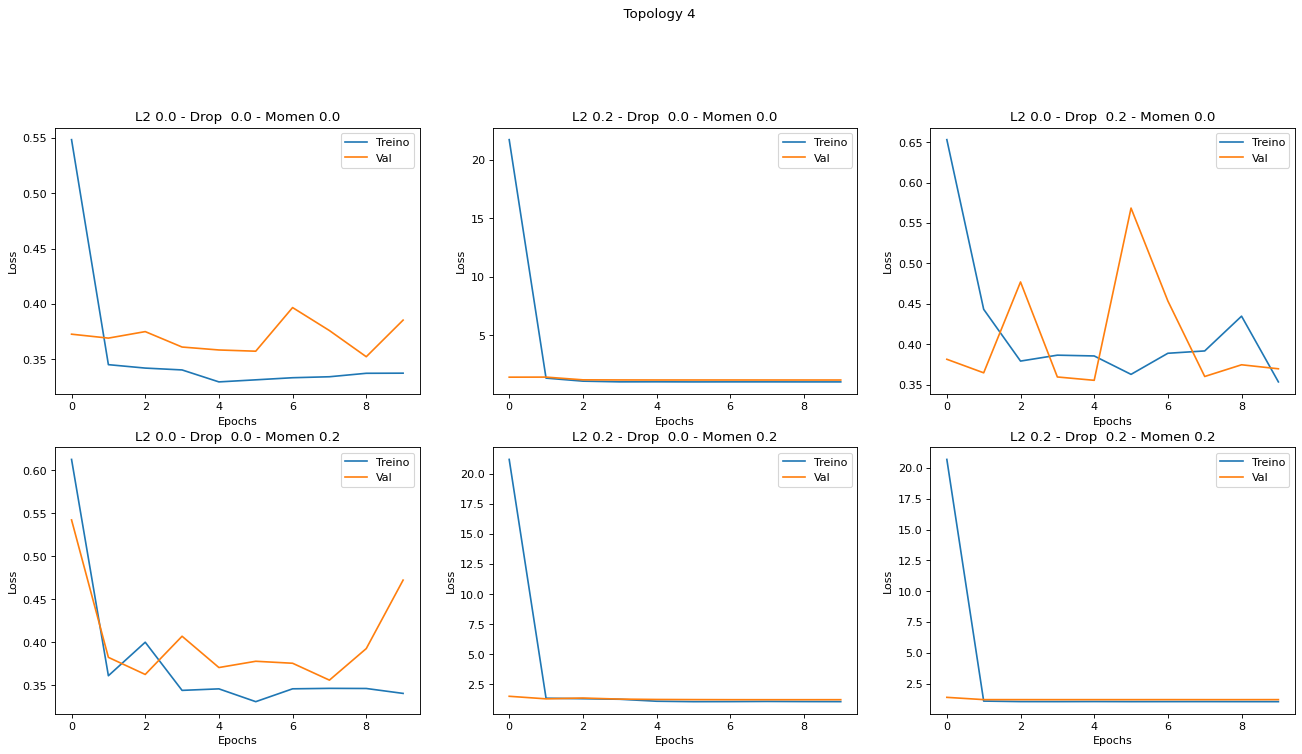

In [41]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 4")
for i in range(len(model_4)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_4[i].history['loss'], label="Treino")
  plt.plot(      history_4[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation for Topology 4

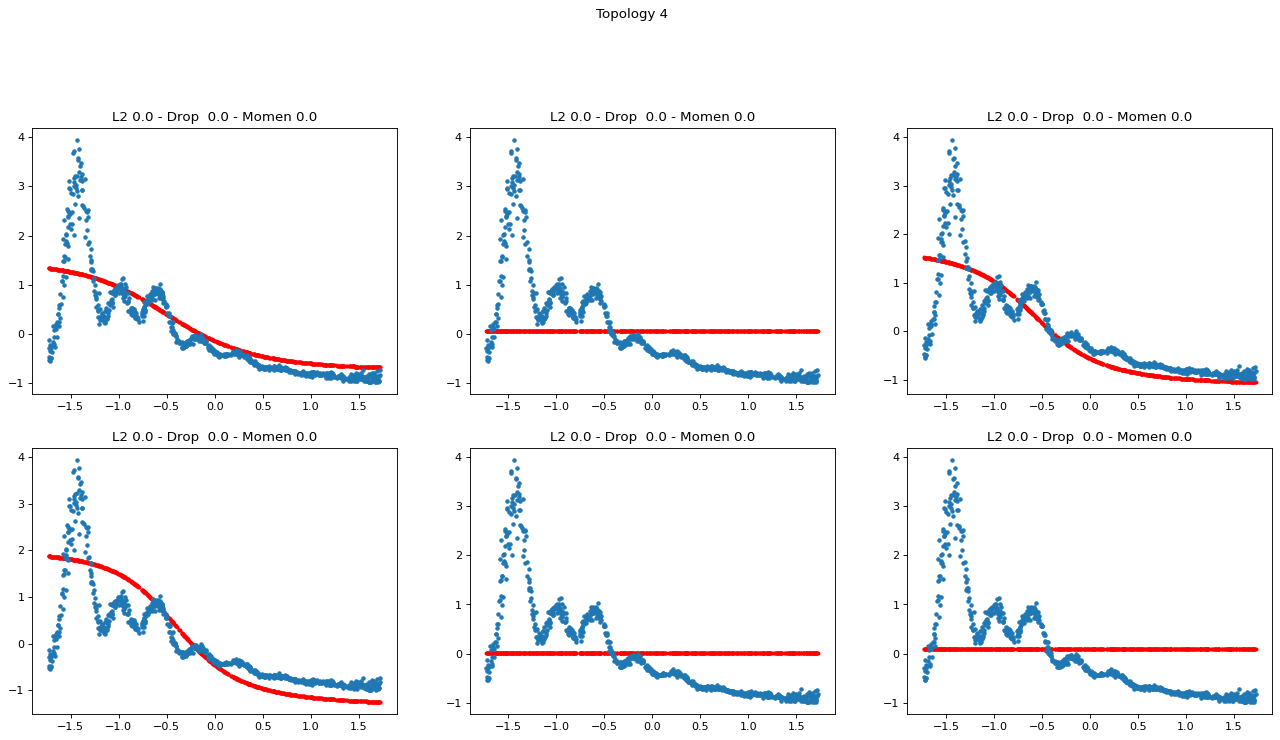

In [42]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 4')
for i in range(len( model_4)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_4[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

In [43]:
score_4 = []
for i in range(len(           model_4)): 
  score_4.append(             model_4[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_4'+str(i))
  print("Test loss:",   round(score_4[i][0],5))
  print("Test metric:", round(score_4[i][1],5),'\n')

Model_40
Test loss: 0.3029
Test metric: 0.35522 

Model_41
Test loss: 0.97522
Test metric: 0.77973 

Model_42
Test loss: 0.2987
Test metric: 0.35683 

Model_43
Test loss: 0.40047
Test metric: 0.47385 

Model_44
Test loss: 0.96883
Test metric: 0.76504 

Model_45
Test loss: 0.98426
Test metric: 0.79241 



# References

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8